# SSC BERT


Cohan et al (2019) propose a strategy of how exploit BERT to deal with the Sequential Sentence Classification (SSC) task: we concatenate sentences by inserting a \[SEP\] token between two subsequent sentences; we feed BERT with the concatenation, or block of sentences, and we perform classification from the embeddings of \[SEP\] tokens.

This notebook tries to replicate Cohan et al (2019) models. The dataset was also published by the in the same work.

### References:
- Arman Cohan, Iz Beltagy, Daniel King, Bhavana Dalvi, Dan Weld. **Pretrained Language Models for Sequential Sentence Classification**. 2019. EMNLP.

### Notebook parameters

In [1]:
MAX_SENTENCE_LENGTH = 75
SENTENCE_LENGHT_UNIT = 'token' # 'char' or 'token'
N_EPOCHS = 2
BATCH_SIZE = 4
LEARNING_RATE = 5e-5
DROPOUT = 0.1
USE_MLP = False
MAX_SEQUENCE_LENGTH = 512 # max number of tokens in a block

In [2]:
model_id = 'allenai/scibert_scivocab_uncased' # id from HuggingFaces
embedding_dim = 768
model_reference = 'SSC_SciBERT'

### Dependencies

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import transformers
transformers.__version__

'4.17.0'

In [6]:
import torch
torch.__version__

'1.9.0a0+df837d0'

In [7]:
import sklearn
sklearn.__version__

'0.24.1'

In [8]:
import numpy as np
np.__version__

'1.19.2'

In [9]:
import pandas as pd
pd.__version__

'1.1.4'

### Random numbers' seed

In [10]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Loading and preparing dataset

In [11]:
label_to_idx = {
  'background' : 0, 
  'objective' : 1,
  'method': 2, 
  'result': 3, 
  'other': 4
}

labels = [None] * len(label_to_idx)
for l, idx in label_to_idx.items():
  labels[idx] = l
labels

['background', 'objective', 'method', 'result', 'other']

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [13]:
import json

dataset_path = './'

def load_json(file_name):
    blocks = []
    labels = []
    with open(dataset_path + file_name) as f:
        for line in f:
            json_dic = json.loads(line)
            blocks.append(json_dic['sentences'])
            labels.append(json_dic['labels'])
    return blocks, labels


In [14]:
from torch.utils.data import Dataset

class SSCDatasetA(Dataset):
    def __init__(self, tokenizer, file_name, max_sent_len, max_block_len=512):
        """
        Creates a dataset from data in JSON file. Each item is this dataset object is a sentence block.
        Arguments:
            tokenizer: tokenizer of the transformer model exploited as sentence encoder.
            file_name: name of JSON file.
            max_sent_len: maximum number of characters in a sentence.
            max_block_len: maximum number of tokens in a block.
        """
        # Be aware as blocks may have different numbers of sentences, they may have different numbers of labels.
        # For each block, we have number of labels equals to number of sentences.
        blocks, self.labels = load_json(file_name)
        # self.labels: list of list of strings (one list of labels for each block). shape: (n blocks, n labels in block)
        for b, l in zip(blocks, self.labels):
            if len(b) != len(l):
                print('ERROR in the block:', b)
                raise ValueError('Number of sentences different of the number of labels: {len(b)} != {len(l)}')
        
        self.targets = []  # list of tensors (one 1-D tensor for each block). shape: (n blocks, n labels in block)
        for label_list in self.labels:
            self.targets.append(
                torch.tensor([label_to_idx[l] for l in label_list], dtype=torch.long)
            )
        
        # adjusting the length of each sentence
        for block in blocks:
            for i in range(len(block)):
                if len(block[i]) > max_sent_len:
                    block[i] = block[i][0:max_sent_len]
        
        self.blocks = []
        for block in blocks:
            self.blocks.append(' [SEP] '.join(block))
        tokens = tokenizer(
            self.blocks, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            return_attention_mask=True, 
            truncation=True, 
            padding='max_length',
            max_length=max_block_len,
            return_tensors='pt'
        )
        # TODO: check if number of SEP tokens is equal to number of labels for each block
        self.input_ids = tokens['input_ids']             # tensor for all blocks. shape: (n blocks, max_block_len)
        self.attention_masks = tokens['attention_mask']  # tensor for all blocks. shape: (n blocks, max_block_len)

    def __getitem__(self, index):
        return {
            'ids': self.input_ids[index],        # tensor of shape (max_block_len)
            'mask': self.attention_masks[index], # tensor of shape (max_block_len)
            'targets': self.targets[index],      # tensor of shape (n of labels in the block)
            'labels': self.labels[index],        # list of size (n of labels in the block)
            'block': self.blocks[index]          # a string
        }
    
    def __len__(self):
        return len(self.labels)


In [15]:
from torch.utils.data import Dataset

class SSCDatasetB(Dataset):
    def __init__(self, tokenizer, file_name, max_sent_len, max_block_len=512):
        """
        Creates a dataset from data in JSON file. Each item is this dataset object is a sentence block.
        Arguments:
            tokenizer: tokenizer of the transformer model exploited as sentence encoder.
            file_name: name of JSON file.
            max_sent_len: maximum number of tokens in a sentence.
            max_block_len: maximum number of tokens in a block.
        """
        # Be aware as blocks may have different numbers of sentences, they may have different numbers of labels.
        # For each block, we have number of labels equals to number of sentences.
        blocks, self.labels = load_json(file_name)
        # self.labels: list of list of strings (one list of labels for each block). shape: (n blocks, n labels in block)
        for b, l in zip(blocks, self.labels):
            if len(b) != len(l):
                print('ERROR in the block:', b)
                raise ValueError('Number of sentences different of the number of labels: {len(b)} != {len(l)}')
        
        self.targets = []  # list of tensors (one 1-D tensor for each block). shape: (n blocks, n labels in block)
        for label_list in self.labels:
            self.targets.append(
                torch.tensor([label_to_idx[l] for l in label_list], dtype=torch.long)
            )
        
        # adjusting the length of each sentence
        for block in blocks:
            for i in range(len(block)):
                sent_ids = tokenizer.encode(
                    block[i], 
                    add_special_tokens=False, 
                    padding=False,
                    truncation=True,
                    max_length=max_sent_len
                )
                block[i] = tokenizer.decode(sent_ids)
        # toekninzing blocks
        self.blocks = []
        for block in blocks:
            self.blocks.append(' [SEP] '.join(block))
        tokens = tokenizer(
            self.blocks, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            return_attention_mask=True, 
            truncation=True, 
            padding='max_length',
            max_length=max_block_len,
            return_tensors='pt'
        )
        self.input_ids = tokens['input_ids']             # tensor for all blocks. shape: (n blocks, max_block_len)
        self.attention_masks = tokens['attention_mask']  # tensor for all blocks. shape: (n blocks, max_block_len)
        
        # checking whether the number of SEP tokens is equal to then number of labels as 
        # truncation might delete SEP tokens
        SEP_id = tokenizer.convert_tokens_to_ids('[SEP]')
        n_sep_tokens = torch.count_nonzero(self.input_ids == SEP_id)
        n_labels = sum(map(lambda l: len(l), self.labels))
        if n_sep_tokens != n_labels:
            raise ValueError((
                f'Number of SEP tokens ({n_sep_tokens}) different from the number of labels ({n_labels}). '
                'Decrease max_sent_len or increase max_block_len to avoid this.'
            ))
        

    def __getitem__(self, index):
        return {
            'ids': self.input_ids[index],        # tensor of shape (max_block_len)
            'mask': self.attention_masks[index], # tensor of shape (max_block_len)
            'targets': self.targets[index],      # tensor of shape (n of labels in the block)
            'labels': self.labels[index],        # list of size (n of labels in the block)
            'block': self.blocks[index]          # a string
        }
    
    def __len__(self):
        return len(self.labels)


In [16]:
def get_dataset(json_file):
    if SENTENCE_LENGHT_UNIT == 'char':
        return SSCDatasetA(tokenizer, json_file, MAX_SENTENCE_LENGTH, MAX_SEQUENCE_LENGTH)
    elif SENTENCE_LENGHT_UNIT == 'token':
        return SSCDatasetB(tokenizer, json_file, MAX_SENTENCE_LENGTH, MAX_SEQUENCE_LENGTH)
    else:
        raise ValueError(f'Invalid option for SENTENCE_LENGHT_UNIT param: "{SENTENCE_LENGHT_UNIT}"')

train_ds = get_dataset('train.jsonl')
#dev_ds = get_dataset('dev.jsonl')
test_ds = get_dataset('test.jsonl')

In [17]:
def collate_batch(batch):
    '''
    Prepares a batch of dataset items.
    Arguments:
        batch: list of dataset items (dictionaries).
    Returns:
        A dictionary with following items:
            'ids': tensor of input ids. Shape: (n blocks in batch, max_tokens)
            'maks': tensor of attention masks. Shape: (n blocks in batch, max_tokens)
            'targets': tensor of golden class ids. Shape: (n sentences)
            'labels': list of golden labels. Shape: (n sentences)
    '''
    labels = []
    targets = []
    blocks = []
    input_ids = None
    masks = None
    for entry in batch:
        labels.extend(entry['labels'])
        targets.extend(entry['targets'])
        blocks.append(entry['block'])
        if input_ids is None:
            input_ids = entry['ids'].reshape(1,-1) # reshape to assure a 2-D tensor when the batch contains just one element
            masks = entry['mask'].reshape(1,-1)
        else:
            input_ids = torch.vstack((input_ids, entry['ids']))
            masks = torch.vstack((masks, entry['mask']))
    return {
        'ids': input_ids, 
        'mask': masks, 
        'targets': torch.tensor(targets, dtype=torch.long), 
        'labels': labels, 
        'blocks': blocks
    }

### Model

In [18]:
class SentenceClassifier(torch.nn.Module):
    def __init__(self, encoder_id, n_classes, dropout_rate, sep_id, embedding_dim, use_mlp, n_hidden_mlp=100):
        '''
        Creates a classifier of sequential sentences as proposed in the Pretrained Language Models 
        for Sequential Sentence Classification paper. This model comprises a pre-trained sentence 
        encoder (BERT, RoBERTa, ALBERT, etc) and a classification head. The last can be a MLP (one 
        hidde layer) or a single layer classifier.
        Arguments:
            encoder_id: ID (string) of the encoder model in Hugging Faces repository.
            n_classes: number of classes.
            dropout_rate: dropout rate of classification layers.
            sep_id: the ID of the [SEP] token.
            embedding_dim: dimension of hidden units in the sentence encoder (e.g., 768 for BERT).
            use_mlp: indicates the use of a MLP classifier (True) or a single layer one (False).
            n_hidden_mlp: the number of hidden units of the MLP classifier.
        '''
        super(SentenceClassifier, self).__init__()
        self.bert = transformers.AutoModel.from_pretrained(encoder_id)
        self.SEP_id = sep_id
        dropout = torch.nn.Dropout(dropout_rate)
        n_classes = n_classes
        if use_mlp:
            dense_hidden = torch.nn.Linear(embedding_dim, n_hidden_mlp)
            torch.nn.init.kaiming_uniform_(dense_hidden.weight)
            relu = torch.nn.ReLU()
            dense_out = torch.nn.Linear(n_hidden_mlp, n_classes)
            torch.nn.init.xavier_uniform_(dense_out.weight)
            self.classifier = torch.nn.Sequential(
                dropout, dense_hidden, relu, dropout, dense_out
            )
        else:
            dense_out = torch.nn.Linear(embedding_dim, n_classes)
            torch.nn.init.xavier_uniform_(dense_out.weight)
            self.classifier = torch.nn.Sequential(
                dropout, dense_out
            )

    def forward(self, input_ids, attention_mask):
        '''
        Each call to this method process a batch of sentence blocks. The model takes account of 
        all sentences in block, but not all sentences in a document. There is no data sharing 
        among the blocks, so the model is unware of when blocks are from same document.
        A block of sentences aggregates many sentences which are separated by 
        a [SEP] token. The first token in the block must be the [CLS] token.
        This method returns one logit tensor for each sentence in the batch.
        Arguments:
            input_ids : tensor of shape (batch_size, n of tokens in block)
            attention_mask : tensor of shape (batch_size, n of tokens in block)
        Returns:
            logits : tensor of shape (n of sentences in batch, n of classes)
        '''
        output_1 = self.bert(
            input_ids=input_ids,              # input_ids.shape: (batch_size, seq_len)
            attention_mask=attention_mask     # attention_mask.shape: (batch_size, seq_len)
        )
        
        # yelds a logit tensor for each SEP token
        # as the blocks may have different number of sentences, we have to iterate blocks
        embeddings = None
        for i in range(input_ids.shape[0]):
            idx_sep = torch.nonzero(input_ids[i] == self.SEP_id, as_tuple=True)[0]
            for idx in idx_sep: # iterates SEP tokens in current block
                sep_emb = output_1.last_hidden_state[i, idx, :] # gets embeddings of a SEP token
                if embeddings is None:
                    embeddings = sep_emb
                else:
                    embeddings = torch.vstack((embeddings, sep_emb))
        # embeddings.shape: (number of sentences in batch, hidden dimension)
        logits = self.classifier(embeddings) # logits.shape: (number of sentences in batch, num of classes)
        
        return logits

### Evaluation function

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

def evaluate(model, test_dataloader, loss_function):
    predictions = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Evaluation'): # iterates batches
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            y_true_batch = batch['targets'].to(device)
            y_hat = model(ids, mask)
            loss = loss_function(y_hat, y_true_batch)
            eval_loss += loss.item()
            predictions_batch = y_hat.argmax(dim=1)
            predictions = torch.cat((predictions, predictions_batch))
            y_true = torch.cat((y_true, y_true_batch))
        predictions = predictions.detach().to('cpu').numpy()
        y_true = y_true.detach().to('cpu').numpy()
        eval_loss = eval_loss / len(test_dataloader)
    t_metrics = precision_recall_fscore_support(
        y_true, 
        predictions, 
        average='macro', 
        zero_division=0
    )
    cm = confusion_matrix(
        y_true, 
        predictions
    )
    
    return eval_loss, t_metrics[0], t_metrics[1], t_metrics[2], cm

### Fine-tuning

In [20]:
import sys, time
from torch.utils.data import DataLoader

def train(labels, train_params, ds_train, ds_test, tokenizer):
    n_epochs = train_params['n_epochs']
    max_sequence_len = train_params['max_sequence_len']
    batch_size = train_params['batch_size']
    
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    
    sentence_classifier = SentenceClassifier(
        model_id, 
        len(labels), # number of classes
        train_params['dropout'], 
        tokenizer.convert_tokens_to_ids('[SEP]'), 
        embedding_dim, 
        train_params['use_mlp']
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(
        sentence_classifier.parameters(), 
        lr=train_params['learning_rate'], 
        betas=(0.9, 0.999), 
        eps=train_params['eps'], 
        weight_decay=train_params['weight_decay']
    )
    
    lr_scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, 
        num_training_steps = len(dl_train) * n_epochs
    )
    
    # pct_start controls LR warmup. If warmup is True, increases LR during the 
    # first 10% of steps. Otherwise, initial LR is equal to max LR
    '''
    num_training_steps = len(dl_train) * n_epochs
    pct_start = 0.1 if train_params['warmup'] else 1e-100
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=train_params['learning_rate'], 
        total_steps=num_training_steps, 
        pct_start=pct_start,    
        anneal_strategy='linear'
    )
    '''
    
    metrics = {} # key: epoch number, value: numpy tensor storing train loss, test loss, Precision, Recall, F1
    confusion_matrices = {} # key: epoch number, value: scikit-learn's confusion matrix
    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0
        sentence_classifier.train()
        for i_batch, train_data in enumerate(tqdm(dl_train, desc=f'Epoch {epoch} (train)')): # iterates batches
            optimizer.zero_grad()
            ids = train_data['ids'].to(device)
            mask = train_data['mask'].to(device)
            y_hat = sentence_classifier(ids, mask)
            y_true = train_data['targets'].to(device)
            loss = criterion(y_hat, y_true)
            epoch_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(sentence_classifier.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
        epoch_loss = epoch_loss / len(dl_train)
        # evaluation
        optimizer.zero_grad()
        eval_loss, p, r, f1, cm = evaluate(sentence_classifier, dl_test, criterion)
        #storing metrics
        metrics[epoch] = np.array([epoch_loss, eval_loss, p, r, f1])
        confusion_matrices[epoch] = cm
        print(f'=> Epoch {epoch}')
        print(f'  Train loss: {epoch_loss:.6f}')
        print(f'  Test loss:  {eval_loss:.6f}')
        print(f'  Precision:  {p:.6f}')
        print(f'  Recall:     {r:.6f}')
        print(f'  F1:         {f1:.6f}')
        cmDisplay = ConfusionMatrixDisplay(cm, display_labels=labels)
        cmDisplay.plot()
        cmDisplay.ax_.set_title(f'Epoch: {epoch}')
        cmDisplay.ax_.figure.autofmt_xdate(rotation=45)
        time.sleep(0.5) # in order to don't mess the progress bars
    
    return metrics, confusion_matrices


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluation: 100%|██████████| 57/57 [00:04<00:00, 13.61it/s]


=> Epoch 1
  Train loss: 1.106818
  Test loss:  0.523015
  Precision:  0.812535
  Recall:     0.802126
  F1:         0.803987


Evaluation: 100%|██████████| 57/57 [00:04<00:00, 13.20it/s]


=> Epoch 2
  Train loss: 0.794184
  Test loss:  0.484928
  Precision:  0.822683
  Recall:     0.803896
  F1:         0.807177


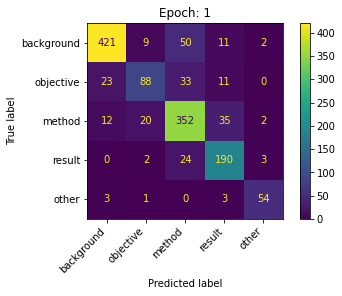

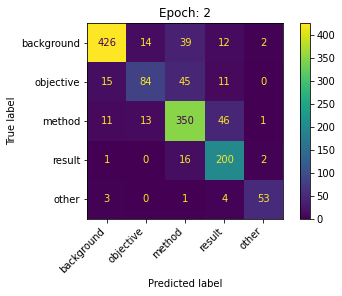

In [21]:
### %%time
# Training params
train_params = {
  'n_epochs' : N_EPOCHS, 
  'batch_size' : BATCH_SIZE,
  'learning_rate' : LEARNING_RATE, 
  'weight_decay' : 1e-3, 
  'eps' : 1e-8, 
  'dropout' : DROPOUT, 
  'use_mlp' : USE_MLP,
  'warmup' : False, 
  'max_sequence_len' : MAX_SEQUENCE_LENGTH
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
raw_metrics, confusion_matrices = train(labels, train_params, train_ds, test_ds, tokenizer)

metrics = pd.DataFrame(columns=['Epoch', 'Train loss', 'Test loss', 'Precision', 'Recall', 'F1'])
for i, (epoch, scores) in enumerate(raw_metrics.items()):
  metrics.loc[i] = [
      f'{epoch}', 
      f'{scores[0]:.6f}',  # train loss
      f'{scores[1]:.6f}',  # test loss
      f'{scores[2]:.4f}',  # precision
      f'{scores[3]:.4f}',  # recall
      f'{scores[4]:.4f}'   # f1
    ]

### Outline

In [22]:
from datetime import datetime

def save_report(metrics, labels, confusion_matrices, train_params, dest_dir):
  """
  Arguments:
    metrics : A pandas Dataframe with the metrics.
    labels : list of all labels.
    confusion_matrices : A dictionary => key: fold_id, value: dictionary (key: epoch, value: confusion matrix)
    train_params : A dictionary.
    dest_dir : The directory where the report will be saved.
  """
  report = (
      'RESULTS REPORT\n'
      f'Model: {model_reference}\n'
      f'Encoder: {model_id}\n'
      'Train scheme: fine-tuning\n'
      f'Batch size: {train_params["batch_size"]}\n'
      f'Maximum sentence length: {MAX_SENTENCE_LENGTH}\n'
      f'Sentence length unit: {SENTENCE_LENGHT_UNIT}\n'
      f'Maximum number of tokens in a block: {train_params["max_sequence_len"]}\n'
      f'Dropout rate: {train_params["dropout"]}\n'
      f'Learning rate: {train_params["learning_rate"]}\n'
      f'Eps: {train_params["eps"]}\n'
      f'LR warmup: {train_params["warmup"]}\n'
      f'Use MLP: {train_params["use_mlp"]}\n'
      f'Weight decay: {train_params["weight_decay"]}\n\n'
  )
  
  report += 'Metrics:\n'
  report += metrics.to_string(index=False, justify='center')
  
  report += f'\nConfusion matrices\n{"-"*18}\n'
  for i, label in enumerate(labels):
    report += f'{label}: {i} \n'
  for e, cm in confusion_matrices.items():
      report += f'Epoch {e}:\n{cm}\n'
    
  with open(dest_dir + f'report-{model_reference}_ft_{datetime.now().strftime("%Y-%m-%d-%Hh%Mmin")}.txt', 'w') as f:
    f.write(report)

In [23]:
save_report(metrics, labels, confusion_matrices, train_params, './')

In [24]:
from IPython.display import display, HTML

metrics_display = display(metrics, display_id='metrics_table')

,Epoch,Train loss,Test loss,Precision,Recall,F1
0,1,1.106818,0.523015,0.8125,0.8021,0.8040
1,2,0.794184,0.484928,0.8227,0.8039,0.8072
